# Programming assignment 1
Following the first problem in the written assignment, set $ρ_{22}$ = 1 and zeros in else- where, solve the system u.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from numba import jit, njit, prange, set_num_threads

# Set the number of threads to use for numba
nthreads = 8
set_num_threads(nthreads)

In [2]:
def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    N is the number of grid points in one direction.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))

    def init_1_4_1_matrix(N=4):
        ex = np.ones(nsq)
        data = np.array([-ex, 4 * ex, -ex])
        offset = np.array([-1, 0, 1])
        u = dia_matrix((data, offset), shape=(N, N)).toarray()
        return u

    def init_one_matrix(N):
        return -np.identity(N)

    def init_zero_matrix(N):
        return np.zeros((N,N))
    
    d_matrix = init_1_4_1_matrix(N)
    o_matrix = init_one_matrix(N)
    z_matrix = init_zero_matrix(N)
    
    '''
    for i in range(N):
        for j in range(N):
            if i == j:
                submartix = init_1_4_1_matrix(N)
            elif abs(i-j) == 1:
                submartix = init_one_matrix(N)
            else:
                submartix = init_zero_matrix(N)
            
            for ii in range(N):
                for jj in range(N):
                    A[i*N+ii][j*N+jj] = submartix[ii][jj]
    '''
    A = init_matrix_kernel(N, A, d_matrix, o_matrix, z_matrix)
    return A

# use numba to speed up the matrix generation
@njit(parallel=True)
def init_matrix_kernel(N,A,d_matrix,o_matrix, z_matrix):
    for i in prange(N):
        for j in prange(N):
            if (i==j):
                submatrix = d_matrix
            elif (abs(i-j)==1):
                submatrix = o_matrix
            else:
                submatrix = z_matrix
            
            for i2 in range(N):
                for j2 in range(N):
                    ii = i2 + i*N
                    jj = j2 + j*N
                    A[ii,jj] = submatrix[i2,j2]   
    return A

# include boundary conditions
def generate_the_rhs_vector_with_size(N=3):
    b = np.zeros(N*N)
    b[4] = 1
    return b

# convert the solution vector to the finite difference grids u[i,j]
def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u

In [3]:
# check the format of A & b
N = 3
A = generate_the_laplace_matrix_with_size(N)
print(A)
b = generate_the_rhs_vector_with_size(N)
print(b)

[[ 4. -1.  0. -1. -0. -0.  0.  0.  0.]
 [-1.  4. -1. -0. -1. -0.  0.  0.  0.]
 [ 0. -1.  4. -0. -0. -1.  0.  0.  0.]
 [-1. -0. -0.  4. -1.  0. -1. -0. -0.]
 [-0. -1. -0. -1.  4. -1. -0. -1. -0.]
 [-0. -0. -1.  0. -1.  4. -0. -0. -1.]
 [ 0.  0.  0. -1. -0. -0.  4. -1.  0.]
 [ 0.  0.  0. -0. -1. -0. -1.  4. -1.]
 [ 0.  0.  0. -0. -0. -1.  0. -1.  4.]]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


[[0.0625 0.125  0.0625]
 [0.125  0.375  0.125 ]
 [0.0625 0.125  0.0625]]


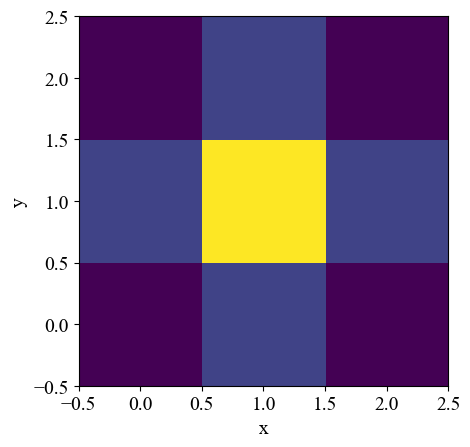

In [4]:
from scipy import linalg
x = linalg.solve(A, b)
u1 = convert_solution(x)
print(u1)
plt.rc('font', family='Times New Roman', size=14)
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(u1.T,origin="lower")
# change font type


# Programming assignment 2
* Consider a 128 x 128 grids in a domain ($-5<x<5$ and $-5<y<5$)
* Assume $\rho(r)= \exp(-\frac{5}{4}r_{1}^2)+\frac{3}{2}\exp(-r_2^2)$
* where $r_1=(x+1.5)^2+y^2$ and $r_2=(x-1.5)^2+Y^2$
* Assume periodic boundary condition.
* solve the corresponding potential of this source function. 
* Draw color and contour plots of the source function and the solution potential.

In [5]:
import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from numba import set_num_threads

# Set the number of threads to use for numba
nthreads = 8
set_num_threads(nthreads)

In [6]:
# generate the N*N rho matrix with denisty filed
def generate_rho(N, buff=0, xmin=-5, xmax=5, ymin=-5,ymax=5):
    x = np.linspace(xmin, xmax, N+2*buff)
    y = np.linspace(ymin, ymax, N+2*buff)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    r1     = (xx+1.5)**2 + yy**2
    r2     = (xx-1.5)**2 + yy**2
    rho    = np.exp(-5/4*(r1**2))+3/2*np.exp(-r2**2)
    return xx, yy, rho

Text(0, 0.5, 'y')

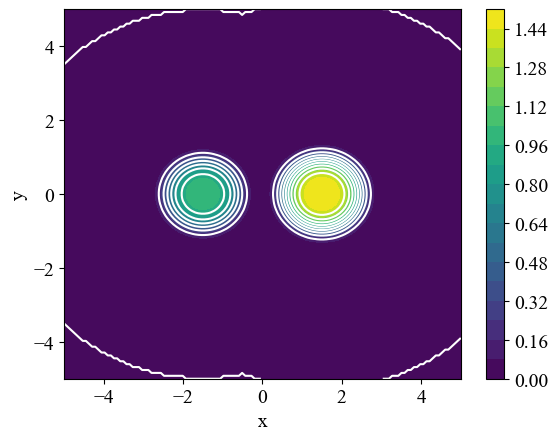

In [7]:
# visualize the density field
xx, yy, rho = generate_rho(128)
'''
plt.imshow(rho, origin="lower")
plt.colorbar()
plt.contour(rho,colors="w")
'''
# plot the density field with contour
plt.contourf(xx, yy, rho, 20)
plt.colorbar()
plt.contour(xx, yy, rho, 10, colors="w")
plt.xlabel("x")
plt.ylabel("y")

In [8]:
def generate_mesh(nx, ny, buff=1, 
                  xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0):
    """
    Generate 2D mesh grids for solving Laplace equation.

    Parameters
    ----------
    nx : int
        Number of grid points in x direction.
    ny : int
        Number of grid points in y direction.
    buff : int
        Number of ghost cells around the domain.
    xmin : float
        Minimum value of x.
    xmax : float
        Maximum value of x.
    ymin : float
        Minimum value of y.
    ymax : float
        Maximum value of y.

    Returns
    -------
    u : 2D numpy array
        Initial guess
    x : 2D numpy array
        Mesh grid for x.
    y : 2D numpy array
        Mesh grid for y.

    dx : float
        Grid spacing in x.
    dy : float
        Grid spacing in y.
        
    """
    #TODO:
    # 1. Generate mesh grid for x and y
    # 2. Calculate grid spacing dx and dy
    # 3. Return x, y, dx, dy

    u = np.zeros((nx+2*buff, ny+2*buff))
    x = np.linspace(xmin, xmax, nx+2*buff)
    y = np.linspace(ymin, ymax, ny+2*buff)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    return u, x, y, dx, dy
#
# Combiation of three methods
@njit(parallel=True)
def jocobi(u, uold, rho, omega, nx, ny, dx, dy):
    # u[ny+2*buff, nx+2*buff], from 1 to ny+1 is the real domain without ghost cells
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            u[i, j] = 0.25*(uold[i-1, j] + uold[i+1, j] + uold[i, j-1] + uold[i, j+1] - dx**2*rho[i,j])
    return u

@njit(parallel=True)
def gauss_seidel(u, uold, rho, omega, nx, ny, dx, dy):
    flag = 0
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            u[i, j] = 0.25*(u[i-1, j] + uold[i+1, j] + u[i, j-1] + uold[i, j+1] - dx**2*rho[i,j])    
    return u

@njit(parallel=True)
def successive_over_relaxation(u, uold, rho, omega, nx, ny, dx, dy):
    u = gauss_seidel(u, uold, rho, omega, nx, ny, dx, dy)
    u = (1.0 - omega)*uold + omega*u
    return u

def update_bc(u):
    u[0,:] = 0.0    # left boundary
    u[-1,:] = 0.0   # right boundary
    u[:,0] = 0.0    # bottom boundary
    u[:,-1] = 0.0   # top boundary
    return u

def relax(u, tolerence, rho, maxiter=100000, method = 'jocobi', omega=1.0):
    
    if method == 'jocobi':
        iter_func = jocobi
    elif method == 'gauss_seidel':
        iter_func = gauss_seidel
    elif method == 'sor':
        iter_func = successive_over_relaxation
    else:
        raise ValueError('Invalid method, choose from jocobi, gauss_seidel, sor')

    nx, ny = u.shape # including ghost cells
    u = update_bc(u)
    err_list = []
    iter = []
    for n in range(maxiter):
        uold = u.copy()
        u = iter_func(u, uold, rho, omega, nx, ny, dx, dy)
        err = np.linalg.norm(u - uold)
        iter.append(n)
        err_list.append(err)
        if err < tolerence:
            break

    return u, err_list, iter


In [9]:
# 128 gauss_seidel
u, x, y, dx, dy = generate_mesh(128,128, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
xx, yy, rho = generate_rho(128, buff=1)
u128_g, err128_g, iter128_g = relax(u, tolerence=1e-6, rho=rho, maxiter=100000, method='gauss_seidel', omega=1.0)

"\nplt.imshow(u128_g, origin='lower')\nplt.colorbar()\nplt.contour(u128_g, colors='w')\n\n"

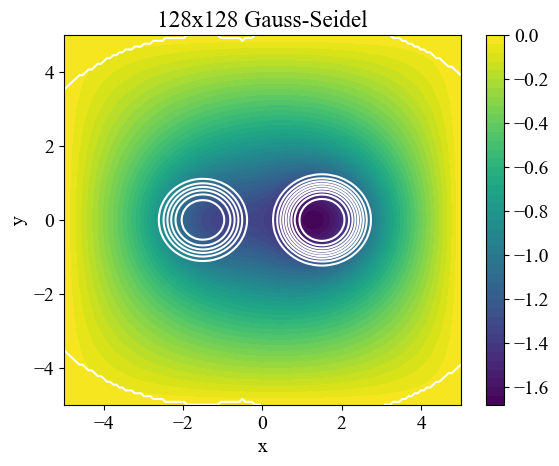

In [10]:
# Visualize the solution of 128x128 Gauss-Seidel
plt.contourf(xx, yy, u128_g, 50)
plt.colorbar()
plt.contour(xx, yy, rho, 10, colors="w")
plt.title('128x128 Gauss-Seidel')
plt.xlabel("x")
plt.ylabel("y")
'''
plt.imshow(u128_g, origin='lower')
plt.colorbar()
plt.contour(u128_g, colors='w')

'''

In [11]:
# 128 Jocobi
u, x, y, dx, dy = generate_mesh(128,128, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
xx, yy, rho = generate_rho(128, buff=1)
u128_j, err128_j, iter128_j = relax(u, tolerence=1e-7, rho=rho, maxiter=100000, method='jocobi', omega=1.0)
#print(u128_j)

Text(0, 0.5, 'y')

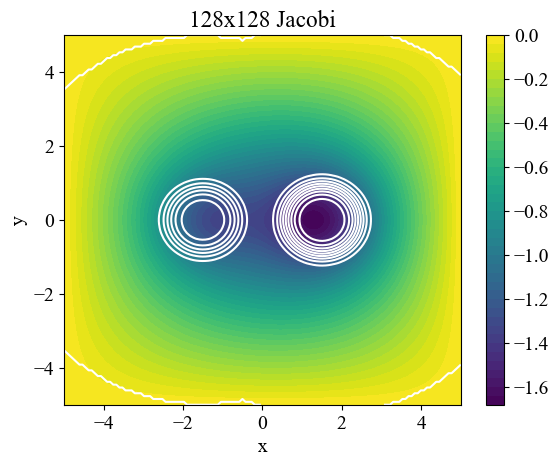

In [12]:
# Visualize the solution of 128x128 Jacobi
plt.contourf(xx, yy, u128_j, 50)
plt.colorbar()
plt.contour(xx, yy, rho, 10, colors="w")
plt.title('128x128 Jacobi')
plt.xlabel("x")
plt.ylabel("y")

In [13]:
# 128 SOR with omega = 1.2
u, x, y, dx, dy = generate_mesh(128,128, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
xx, yy, rho = generate_rho(128, buff=1)
u128_s_w12, err128_s_w12, iter128_s_w12 = relax(u, tolerence=1e-6, rho=rho, maxiter=20000, method='sor', omega=1.2)

Text(0, 0.5, 'y')

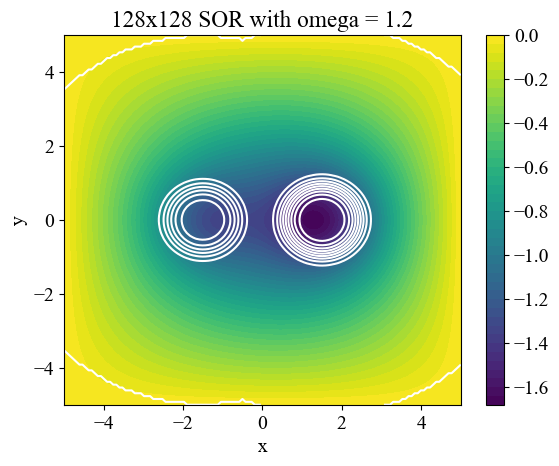

In [14]:
# Visualize the solution of SOR with omega = 1.2
plt.contourf(xx, yy, u128_s_w12, 50)
plt.colorbar()
plt.contour(xx, yy, rho, 10, colors="w")
# using latex in the title omega = 1.2
plt.title(r'128x128 SOR with omega = 1.2')
plt.xlabel("x")
plt.ylabel("y")

In [15]:
# 128 SOR with omega = 1.5
u, x, y, dx, dy = generate_mesh(128,128, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
xx, yy, rho = generate_rho(128, buff=1)
u128_s_w15, err128_s_w15, iter128_s_w15 = relax(u, tolerence=1e-6, rho=rho, maxiter=100000, method='sor', omega=1.5)

Text(0, 0.5, 'y')

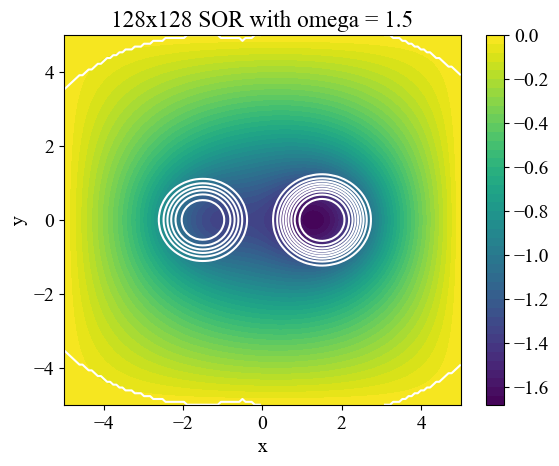

In [16]:
# Visualize the solution of 128x128 SOR with omega = 1.5
plt.contourf(xx, yy, u128_s_w15, 50)
plt.colorbar()
plt.contour(xx, yy, rho, 10, colors="w")
plt.title('128x128 SOR with omega = 1.5')
plt.xlabel("x")
plt.ylabel("y")

In [17]:
# 128 SOR with omega = 2.0
u, x, y, dx, dy = generate_mesh(128,128, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
xx, yy, rho = generate_rho(128, buff=1)
u128_s_w20, err128_s_w20, iter128_s_w20 = relax(u, tolerence=1e-6, rho=rho, maxiter=100000, method='sor', omega=2.0)

/var/folders/s6/9k31c3vn7kzdpx0f4s295dlh0000gn/T/ipykernel_1920/831881530.py:99: RuntimeWarning: overflow encountered in subtract
  err = np.linalg.norm(u - uold)


Text(0, 0.5, 'y')

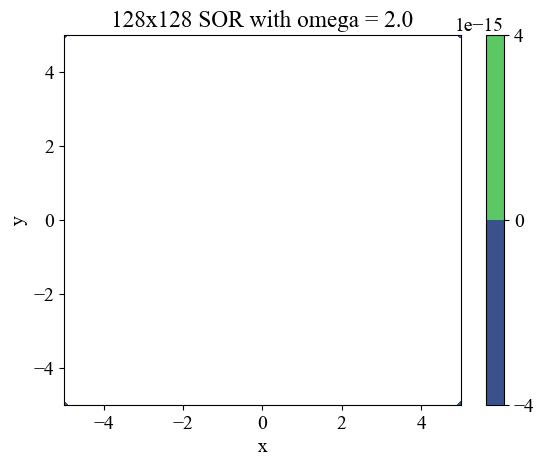

In [18]:
# Visualize the solution of 128x128 SOR with omega = 2.0
plt.contourf(xx, yy, u128_s_w20, 50)
plt.colorbar()
plt.contour(xx, yy, rho, 10, colors="w")
plt.title('128x128 SOR with omega = 2.0')
plt.xlabel("x")
plt.ylabel("y")

# Programming assignment 3
* Following the above question, plots errors as functions of iterations for (1) Jacobi method, (2) Gauss-Seidel method, and (3) Successive Over-Relaxation method with w = 1.2, 1.5, and 2.0 (plot them on the same figure).

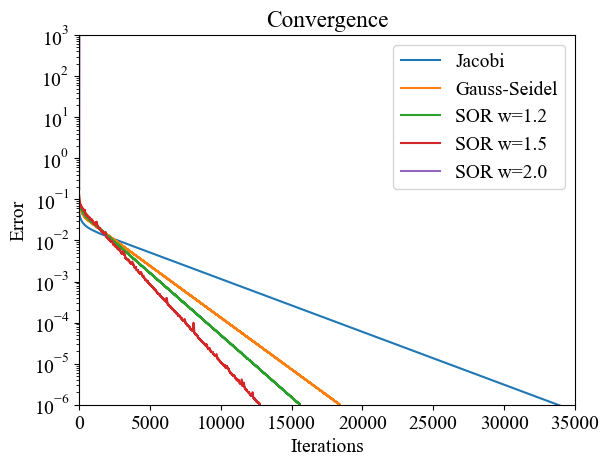

In [19]:
# plots errors as functions of iterations for (1) Jacobi method, (2) Gauss-Seidel method, and (3) Successive Over-Relaxation method with w = 1.2, 1.5, and 2.0 

plt.figure()
plt.plot(iter128_j, err128_j, label='Jacobi')
plt.plot(iter128_g, err128_g, label='Gauss-Seidel')
plt.plot(iter128_s_w12, err128_s_w12, label='SOR w=1.2')
plt.plot(iter128_s_w15, err128_s_w15, label='SOR w=1.5') 
plt.plot(iter128_s_w20, err128_s_w20, label='SOR w=2.0')
plt.yscale('log')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Convergence')
plt.xlim(0, 35000)
plt.ylim(10e-7, 10e2)
plt.show()

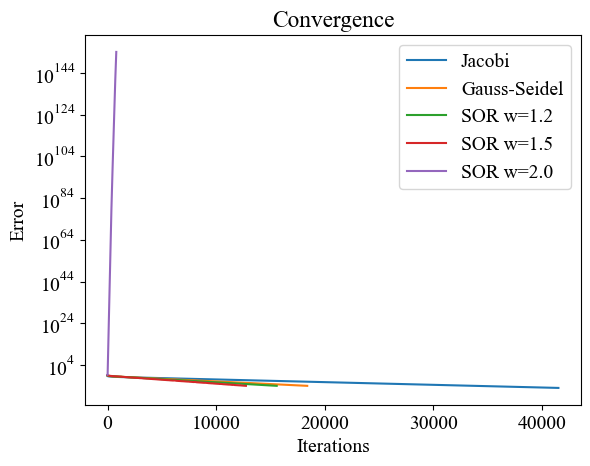

In [20]:
# plots errors as functions of iterations for (1) Jacobi method, (2) Gauss-Seidel method, and (3) Successive Over-Relaxation method with w = 1.2, 1.5, and 2.0 

plt.figure()
plt.plot(iter128_j, err128_j, label='Jacobi')
plt.plot(iter128_g, err128_g, label='Gauss-Seidel')
plt.plot(iter128_s_w12, err128_s_w12, label='SOR w=1.2')
plt.plot(iter128_s_w15, err128_s_w15, label='SOR w=1.5') 
plt.plot(iter128_s_w20, err128_s_w20, label='SOR w=2.0')
plt.yscale('log')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Convergence')
#plt.xlim(0, 35000)
#plt.ylim(10e-7, 10e2)
plt.show()

# Programming assignment 4
* Now, consider an error tolerance = $10^{−7}$, measure the total computing time with 32 × 32, 64 × 64, and 128 × 128 grids, using (1) sparse matrix solver, (2) Jacobi method, (3) Gauss-Seidel method, (4) SOR with w = 1.2 and 1.5. 
* Plot the computing times as functions of grid resolutions with different numerical methods in log-log scale. 
* Describe and discuss how error converge.

In [24]:
# consider an error tolerance ε = 10−7, measure the total computing time with 32 × 32, 64 × 64, and 128 × 128 grids, using (1) sparse matrix solver, (2) Jacobi method, (3) Gauss-Seidel method, (4) SOR with w = 1.2 and 1.5. 
import time
from scipy.sparse import csc_matrix
from scipy.sparse import linalg as splinalg

In [25]:
# sparse matrix solver
resolutions = np.array([32,64,128])
times_sparse       = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    A = generate_the_laplace_matrix_with_size(N)
    b = generate_the_rhs_vector_with_size(N)
    t1 = time.time()
    x  = splinalg.spsolve(A,b)
    t2 = time.time()
    times_sparse[i] = (t2-t1)

print(times_sparse)


Measuring resolution N =  32
Measuring resolution N =  64
Measuring resolution N =  128


/Users/rickyyang/anaconda3/envs/comphys/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


[0.00849795 0.07907772 2.15763497]


In [26]:
# Jacobi method
resolutions = np.array([32,64,128])
times_jacobi       = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    u, x, y, dx, dy = generate_mesh(N,N, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
    t1 = time.time()
    
    xx, yy, rho = generate_rho(N, buff=1)
    u, err, iter = relax(u, tolerence=1e-7, rho=rho, maxiter=100000, method='sor', omega=1.0)
    t2 = time.time()
    times_jacobi[i] = (t2-t1)

print(times_jacobi)

Measuring resolution N =  32
Measuring resolution N =  64
Measuring resolution N =  128
[0.06495881 0.23134804 2.43755698]


In [27]:
# Gauss-Seidel method
resolutions = np.array([32,64,128])
times_gs      = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    u, x, y, dx, dy = generate_mesh(N,N, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
    t1 = time.time()

    xx, yy, rho = generate_rho(N, buff=1)
    u, err, iter = relax(u, tolerence=1e-7, rho=rho, maxiter=100000, method='sor', omega=1.0)
    t2 = time.time()
    times_gs[i] = (t2-t1)
    
print(times_gs)

Measuring resolution N =  32
Measuring resolution N =  64
Measuring resolution N =  128
[0.0461781  0.26446319 2.37769794]


In [28]:
# SOR method w = 1.2
resolutions = np.array([32,64,128])
times_sor_w12      = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    u, x, y, dx, dy = generate_mesh(N,N, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
    t1 = time.time()

    xx, yy, rho = generate_rho(N, buff=1)
    u, err, iter = relax(u, tolerence=1e-7, rho=rho, maxiter=100000, method='sor', omega=1.2)
    t2 = time.time()
    times_sor_w12[i] = (t2-t1)

print(times_sor_w12)

Measuring resolution N =  32
Measuring resolution N =  64
Measuring resolution N =  128
[0.07401085 0.20962906 1.98465204]


In [29]:
# SOR method w = 1.5
resolutions = np.array([32,64,128])
times_sor_w15      = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    u, x, y, dx, dy = generate_mesh(N,N, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
    t1 = time.time()

    xx, yy, rho = generate_rho(N, buff=1)
    u, err, iter = relax(u, tolerence=1e-7, rho=rho, maxiter=100000, method='sor', omega=1.5)
    t2 = time.time()
    times_sor_w15[i] = (t2-t1)

print(times_sor_w15)

Measuring resolution N =  32
Measuring resolution N =  64
Measuring resolution N =  128
[0.03358316 0.15636683 1.66239095]


In [30]:
# SOR method w = 2.0
resolutions = np.array([32,64,128])
times_sor_w20     = np.zeros(len(resolutions))

for i, N in enumerate(resolutions):
    print("Measuring resolution N = ", N)
    u, x, y, dx, dy = generate_mesh(N,N, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
    t1 = time.time()

    xx, yy, rho = generate_rho(N, buff=1)
    u, err, iter = relax(u, tolerence=1e-7, rho=rho, maxiter=100000, method='sor', omega=2.0)
    t2 = time.time()
    times_sor_w20[i] = (t2-t1)

print(times_sor_w20)

Measuring resolution N =  32


/var/folders/s6/9k31c3vn7kzdpx0f4s295dlh0000gn/T/ipykernel_1920/831881530.py:99: RuntimeWarning: overflow encountered in subtract
  err = np.linalg.norm(u - uold)


Measuring resolution N =  64
Measuring resolution N =  128
[3.428514   3.79212904 9.34899926]


Text(0.5, 1.0, 'Computing Time vs Resolution')

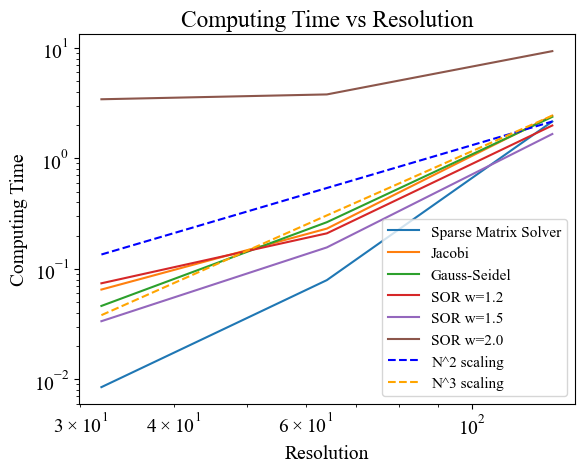

In [40]:
# Plot the computing times as functions of grid resolutions with different numerical methods in log-log scale. 
plt.figure()
plt.plot(resolutions, times_sparse, label='Sparse Matrix Solver')
plt.plot(resolutions, times_jacobi, label='Jacobi')
plt.plot(resolutions, times_gs, label='Gauss-Seidel')
plt.plot(resolutions, times_sor_w12, label='SOR w=1.2')
plt.plot(resolutions, times_sor_w15, label='SOR w=1.5')
plt.plot(resolutions, times_sor_w20, label='SOR w=2.0')
plt.plot(resolutions,times_sparse[-1]*resolutions**2/resolutions[-1]**2, '--', label="N^2 scaling", color='b')
plt.plot(resolutions,times_jacobi[-1]*resolutions**3/resolutions[-1]**3, '--', label="N^3 scaling", color='orange')

plt.yscale('log')
plt.xscale('log')
plt.legend(prop={'size': 11})
plt.xlabel('Resolution')
plt.ylabel('Computing Time')
plt.title('Computing Time vs Resolution')
